**Importing libraries**

In [202]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**PIPELINE**
- Get table of users we have the images of
- Get table of users we have the demographics of
- Preprocessing of the demographics table
- Merge the two tables
- Demographics analysis on the merged table

### 1. Get table of subjects we have the images of

This csv contains all the images that we are going to use with their user. It also contain a few more information about the images and the users, but not all of them (more can be obtained by linking this table to other files)

In [134]:
downladed_images_df = pd.read_csv('C:\\Users\\Emili\\BIOLAB_project\\downloaded_images_subject_list.csv')
downladed_images_df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I63897,941_S_1363,MCI,F,70,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/12/2007,NiFTI,5/20/2023
1,I123812,941_S_1311,MCI,M,71,m18,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,9/21/2008,NiFTI,5/20/2023
2,I143861,941_S_1311,MCI,M,71,m24,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/31/2009,NiFTI,5/20/2023
3,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,5/20/2023
4,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,5/20/2023


In [135]:
print('Total number of images: ', len(downladed_images_df))
print('Total number of subjects: ', len(downladed_images_df['Subject'].unique()))

Total number of images:  2495
Total number of subjects:  648


In [136]:
downladed_images_df.isna().any().sum()

0

There are no missing values from this table

### 2. Get table of users we have the demographics of

Let's download now a demographic table to add more attributes to the users. The meaning of each column is explained at the following link:
https://adni.loni.usc.edu/data-dictionary-search/

In both tables, 1 record (row) corresponds to 1 image

In [137]:
demographics_df = pd.read_csv('C:\\Users\\Emili\\BIOLAB_project\\PTDEMOG_21May2023.csv')
demographics_df.head()

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSOURCE,PTGENDER,...,PTTLANG,PTPLANG,PTPSPEC,PTCOGBEG,PTMCIBEG,PTADBEG,PTADDX,PTETHCAT,PTRACCAT,update_stamp
0,ADNI1,18,2,107,sc,sc,2005-08-17,NaN,1.0,1.0,...,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2005-08-17 00:00:00.0
1,ADNI1,20,1,10,f,f,2005-08-18,NaN,1.0,2.0,...,-4.0,-4.0,-4,NaN,NaN,-4.0,NaN,-4.0,-4.0,2005-08-18 00:00:00.0
2,ADNI1,22,3,107,sc,sc,2005-08-18,NaN,1.0,1.0,...,1.0,1.0,-4,NaN,NaN,1999.0,NaN,2.0,5.0,2005-08-18 00:00:00.0
3,ADNI1,24,4,10,sc,sc,2005-08-18,NaN,1.0,1.0,...,2.0,2.0,-4,NaN,NaN,-4.0,NaN,1.0,5.0,2005-08-18 00:00:00.0
4,ADNI1,26,5,107,sc,sc,2005-08-23,NaN,1.0,1.0,...,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2005-08-23 00:00:00.0


In [138]:
print('Total number of participants:', len(demographics_df['RID'].unique()))

Total number of participants: 4079


### 3. Preprocessing of the demographics table

**Keeping only one record per user**

Some people participated to more than one phase of the trials (e.g. ADNI1, ADNIGO, ADNI2, ADNI3), and we even have data of the same user for the same phase. We want to keep only one record per user, so we will keep the one with the most recent phase (the rows are already orderer in a chronologically way, meaning ADNI1 -> ADNIGO -> ADNI2 -> ADNI3).

In [139]:
demographics_df['Phase'].value_counts()

Phase
ADNI2     1665
ADNI1     1443
ADNI3     1096
ADNIGO     651
Name: count, dtype: int64

As we can see from the example below, participant may have some missing values in one record and not the other. For this reason we will keep the record with the most information by keeping only one record per users after having eliminated the rows with missing values.

In [140]:
demographics_df[demographics_df['RID'] == 1417]

,Phase,ID,RID,SITEID,VISCODE,VISCODE2,USERDATE,USERDATE2,PTSOURCE,PTGENDER,...,PTTLANG,PTPLANG,PTPSPEC,PTCOGBEG,PTMCIBEG,PTADBEG,PTADDX,PTETHCAT,PTRACCAT,update_stamp
1368,ADNI1,2810,1417,41,sc,sc,2007-06-27,NaN,1.0,1.0,...,1.0,1.0,-4,NaN,NaN,-4.0,NaN,2.0,5.0,2007-06-27 00:00:00.0
1418,ADNI1,2936,1417,41,m12,m12,2008-07-29,NaN,1.0,-4.0,...,-4.0,-4.0,-4,NaN,NaN,-4.0,NaN,-4.0,-4.0,2008-07-29 00:00:00.0
1439,ADNI1,2980,1417,41,m18,m18,2013-07-08,NaN,2.0,-4.0,...,-4.0,-4.0,-4,NaN,NaN,-4.0,NaN,-4.0,-4.0,2013-07-08 00:00:00.0
1544,ADNIGO,250,1417,37,sc,sc,2010-09-07,NaN,1.0,1.0,...,1.0,1.0,-4,NaN,2006.0,NaN,NaN,2.0,5.0,2013-03-22 15:23:58.0
2074,ADNIGO,1326,1417,37,m36,m36,2011-09-01,NaN,1.0,NaN,...,NaN,NaN,-4,NaN,NaN,NaN,NaN,NaN,NaN,2012-11-16 09:42:48.0
2368,ADNI2,564,1417,37,v06,m48,2011-09-02,2013-07-08,1.0,1.0,...,1.0,1.0,-4,2006.0,NaN,NaN,9999.0,2.0,5.0,2013-07-08 19:18:56.0


**Selecting attributes**

- RID = Participant roster ID, ID = Record ID -> to merge the two tables
- USERDATE = Date when record was created
- PTSOURCE = Source of the participant (1=Participant Visit, 2=Telephone Call)
- PTGENDER = Gender of the participant (1=Male, 2=Female, -4=Missing) -> use it to check merge
- PTEDUCAT = Years of education of the participant (0-20, -1 or-4=Missing)
- PTMARRY = Marital status of the participant (1=Married; 2=Widowed; 3=Divorced; 4=Never married; 
            5 or -4=Unknown)
- PTDOBYY = Year of birth of the participant -> use it to check merge
- PTHAND = Handedness of the participant (1=Right, 2=Left)
- PTWORKHS = Does the participant have a work history sufficient to exclude mental retardation
            (1=Yes, 2=No, -4=Missing)
- PTWORK = Primary occupation during most of adult life (-4=Missing)
- PTWRECNT = Most recent occupation (-4=Missing)
- PTNOTRT =  Participant Retired? (1=Yes, 0=No, 2=Not applicable, -4=Missing)
- PTRTYR = Retirement Date (-4=Missing)
- PTHOME = Type of participant residence (1=House; 2=Condo/Co-op (owned); 3=Apartment (rented),
           4=Mobile Home, 5=Retirement Community, 6=Assisted Living, 7=Skilled Nursing Facility,8=Other (specify), -4=Missing)
- PTTLANG = Language to be used for testing the Participant (1=English, 2=Spanish, -4=Missing)
- PTPLANG = Participant's Primary Language (1=English, 2=Spanish, 3=Other, -4=Missing)
- PTCOGBEG = Year of onset of cognitive symptoms (best estimate) (9999=Missing)
- PTMCIBEG = Year of onset of Mild Cognitive Impairment symptoms (best estimate)
- PTADBEG = Year of onset of Alzheimer's disease symptoms (best estimate) (-1 or -4=Missing)
- PTADDX = Year of Alzheimer's Disease diagnosis (9999=Missing)
- PTETHCAT = Ethnicity of the participant (1=Hispanic or Latino, 2=Not Hispanic or Latino, 
             3=Other, -4=Missing)
- PTRACCAT = Race of the participant (1=American Indian or Alaskan Native; 2=Asian; 3=Native Hawaiian 
             or Other Pacific Islander; 4=Black or African American; 5=White; 6=More than one race; 7=Unknown)

In [141]:
selected_attributes = ['Phase', 'ID', 'RID', 'USERDATE', 'PTGENDER', 'PTEDUCAT', 'PTMARRY','PTDOBYY',
                       'PTHAND', 'PTWORKHS', 'PTWORK', 'PTWRECNT', 'PTSOURCE', 'PTNOTRT', 'PTRTYR',
                       'PTHOME', 'PTTLANG', 'PTPLANG', 'PTCOGBEG', 'PTMCIBEG', 'PTADBEG', 'PTADDX',
                       'PTETHCAT', 'PTRACCAT']

demographics_df = demographics_df[selected_attributes]

In [142]:
for attribute in selected_attributes:
    print(f"Missing values for {attribute}",
          (demographics_df['PTSOURCE'].isna().sum() +
          len(demographics_df[demographics_df[attribute] == -4]) +
          len(demographics_df[demographics_df[attribute] == '-4']) +
          len(demographics_df[demographics_df[attribute] == -4]) +
          len(demographics_df[demographics_df[attribute] == 9999]))
          *100/len(demographics_df), '%\n\n')

Missing values for Phase 0.0411946446961895 %


Missing values for ID 0.0411946446961895 %


Missing values for RID 0.0411946446961895 %


Missing values for USERDATE 0.0411946446961895 %


Missing values for PTGENDER 2.389289392378991 %


Missing values for PTEDUCAT 2.389289392378991 %


Missing values for PTMARRY 0.82389289392379 %


Missing values for PTDOBYY 0.0411946446961895 %


Missing values for PTHAND 2.883625128733265 %


Missing values for PTWORKHS 59.279093717816686 %


Missing values for PTWORK 4.07826982492276 %


Missing values for PTWRECNT 0.82389289392379 %


Missing values for PTSOURCE 0.0411946446961895 %


Missing values for PTNOTRT 1.235839340885685 %


Missing values for PTRTYR 15.798146240988672 %


Missing values for PTHOME 1.0298661174047374 %


Missing values for PTTLANG 3.048403707518023 %


Missing values for PTPLANG 3.007209062821833 %


Missing values for PTCOGBEG 22.409886714727087 %


Missing values for PTMCIBEG 0.0411946446961895 %


Missing values for 

The following attributes have too many missing values -> we will remove them:
- PTWORKHS (59%)
- PTCOGBEG (22%)
- PTADBEG (47%)
- PTADDX (46%)

This row has 15% of missing values, but all of them are the string '-4' -> we won't drop rows with this value but we'll also keep the variable

At this point we decided to remove the last attribute related to cognitive symptoms and diagnosis:
- PTMCIBEG

In [143]:
demographics_df = demographics_df.drop(['PTWORKHS','PTCOGBEG', 'PTMCIBEG',
                                        'PTADBEG', 'PTADDX'], axis=1)

Finally we'll also remove PTETHCAT, since almost every Hispanic or Latino is classified as White race-wise, and the ones that are not are classified as 'More than one race' or 'Unknown':

In [144]:
demographics_df['PTETHCAT'].value_counts()

PTETHCAT
 2.0    4410
 1.0     214
-4.0      76
 3.0      34
Name: count, dtype: int64

In [145]:
demographics_df[demographics_df['PTETHCAT'] == 1]['PTRACCAT'].value_counts()

PTRACCAT
5.0    164
7.0     24
6.0     22
4.0      3
2.0      1
Name: count, dtype: int64

In [146]:
demographics_df = demographics_df.drop(['PTETHCAT'], axis=1)

**Removing missing or biased values**

In [147]:
demographics_df = demographics_df.dropna()
demographics_df = demographics_df[(demographics_df != -4).all(axis=1)]
demographics_df = demographics_df[(demographics_df != -1).all(axis=1)]
demographics_df = demographics_df[(demographics_df != 9999).all(axis=1)]

len(demographics_df)

4298

Lost about **10%** of the data, but now we have no missing values. Now let's also remove instances that may be biased:

We'll use the variable **PTSOURCE** to remove the participants that took the test by phone because they have a higher chance of 'lying'. This will cost us few instances the classes are really imbalanced: almost every participant went to the clinic to take the test instead of doing it by phone

In [148]:
demographics_df['PTSOURCE'].value_counts()

PTSOURCE
1.0    4282
2.0      16
Name: count, dtype: int64

In [149]:
demographics_df = demographics_df[demographics_df['PTSOURCE'] == 1]
demographics_df = demographics_df.drop(['PTSOURCE'], axis=1)

The variable **PTTLANG** tells us that the questionnaires are only available in English or Spanish. We can use **PTPLANG** to remove the participants that don't speak English or Spanish (they can cause bias and removing them will cost us few instances)

In [150]:
demographics_df['PTPLANG'].value_counts()

PTPLANG
1.0    4144
2.0      73
3.0      65
Name: count, dtype: int64

In [151]:
demographics_df = demographics_df[demographics_df['PTPLANG'] != 3]
demographics_df = demographics_df.drop(['PTPLANG'], axis=1)

**Keeping only the most recent record per user (now with no missing values)**

In [152]:
demographics_df['Phase'].value_counts()

Phase
ADNI2     1587
ADNI1     1333
ADNI3      748
ADNIGO     549
Name: count, dtype: int64

In [153]:
demographics_df = demographics_df.drop_duplicates(subset=['RID'], keep='last')
len(demographics_df)

3646

#### **Naming categorical values**

We want to replace the categorical values of the attributes we are going to analyse with their meaning

**PTMARRY**:

In [154]:
demographics_df['PTMARRY'] = demographics_df['PTMARRY'].replace({1: 'Married', 2: 'Widowed',
                                           3: 'Divorced', 4:'Never married', 5: 'Unknown'})
demographics_df['PTMARRY'].value_counts()

PTMARRY
Married          2705
Widowed           415
Divorced          353
Never married     156
Unknown            17
Name: count, dtype: int64

**PTHAND**:

In [155]:
demographics_df['PTHAND'] = demographics_df['PTHAND'].replace({1: 'Right', 2: 'Left'})
demographics_df['PTHAND'].value_counts()

PTHAND
Right    3324
Left      322
Name: count, dtype: int64

**PTGENDER**:

In [156]:
demographics_df['PTGENDER'] = demographics_df['PTGENDER'].replace({1: 'Male', 2: 'Female'})
demographics_df['PTGENDER'].value_counts()

PTGENDER
Male      1919
Female    1727
Name: count, dtype: int64

**PTNOTRT**:

In [157]:
demographics_df['PTNOTRT'] = demographics_df['PTNOTRT'].replace({0: 'No', 1: 'Yes',
                                                                 2: 'Not Applicable'})
demographics_df['PTNOTRT'].value_counts()

PTNOTRT
Yes               3052
No                 559
Not Applicable      35
Name: count, dtype: int64

**PTHOME**:

In [158]:
demographics_df['PTHOME'] = demographics_df['PTHOME'].replace({1: 'House',
                                                               2: 'Condo/Co-op (owned)',
                                                               3: 'Apartment (rented)',
                                                               4: 'Mobile Home',
                                                               5: 'Retirement Community',
                                                               6:'Assisted Living',
                                                               7:'Skilled Nursing Facility',
                                                               8:'Other'})
demographics_df['PTHOME'].value_counts()


PTHOME
House                       2735
Condo/Co-op (owned)          417
Apartment (rented)           285
Retirement Community         118
Other                         35
Mobile Home                   28
Assisted Living               26
Skilled Nursing Facility       2
Name: count, dtype: int64

**PTRACCAT**:

In [159]:
demographics_df['PTRACCAT'] = demographics_df['PTRACCAT'].replace(
    {1: 'American Indian or Alaskan Native',
     2: 'Asian',
     3: 'Native Hawaiian or Other Pacific Islander',
     4: 'Black or African American',
     5: 'White',
     6: 'More than one race',
     7: 'Unknown'})
demographics_df['PTRACCAT'].value_counts()

PTRACCAT
White                                        3302
Black or African American                     236
Asian                                          52
More than one race                             34
Unknown                                        16
American Indian or Alaskan Native               3
Native Hawaiian or Other Pacific Islander       3
Name: count, dtype: int64

### 4. Get weight table

Now we are going to get the weight table by reading the csv file obtained in the get_data_from_xml.ipynb notebook. This attribute will be part of the physical analysis

In [160]:
weight_df = pd.read_csv('C:\\Users\\Emili\\BIOLAB_project\\weight.csv')
weight_df.head()

,RID,Weight
0,295,74.50
1,295,74.10
2,295,72.60
3,295,73.75
4,295,72.90


### 5. Get APOE and TOMM40 tables

Now we are going to get the APOE and TOMM40 tables by reading the csv files obtained in the get_data_from_xml.ipynb notebook and the downloaded csv. These attributes will be part of the genetic analysis

In [161]:
apoe_df = pd.read_csv('C:\\Users\\Emili\\BIOLAB_project\\apoe.csv')
apoe_df['APOE A1'] = apoe_df['APOE A1'].astype('string')
apoe_df['APOE A2'] = apoe_df['APOE A2'].astype('string')
apoe_df.head()

,RID,APOE A1,APOE A2
0,295,3,4
1,295,3,4
2,295,3,4
3,295,3,4
4,295,3,4


In [162]:
tomm40_df = pd.read_csv('C:\\Users\\Emili\\BIOLAB_project\\TOMM40_22May2023.csv')
tomm40_df = tomm40_df.dropna()
tomm40_df['TOMM40_A2'] = tomm40_df['TOMM40_A2'].astype('int')
tomm40_df['TOMM40_A1'] = tomm40_df['TOMM40_A1'].astype('int')
tomm40_df['TOMM40_A2'] = tomm40_df['TOMM40_A2'].astype('string')
tomm40_df['TOMM40_A1'] = tomm40_df['TOMM40_A1'].astype('string')
tomm40_df.head()

,PTID,RID,TOMM40_A1,TOMM40_A2,update_stamp
0,002_S_0295,295,16,21,2011-04-25 18:14:08.0
1,002_S_0413,413,16,34,2011-04-25 18:14:08.0
2,002_S_0559,559,35,35,2011-04-25 18:14:08.0
3,002_S_0619,619,28,28,2011-04-25 18:14:08.0
4,002_S_0685,685,33,34,2011-04-25 18:14:08.0


### 6.Merging the tables

Now it's time to merge the two tables: we want the attributes of demographic_df and weight_df only for the instances available in the image table (the analysis has to be on the participants we actually have the images of)

First we need to get the last four numbers from the 'Subject' code (images dataframe): that is the Roster ID that is present in the demographic dataframe (as 'RID'). We'll use them to merge the two tables

In [163]:
downladed_images_df['RID'] = np.nan

for i in range(len(downladed_images_df)):
     m = re.search('_S_(\d+)', downladed_images_df['Subject'][i])
     downladed_images_df['RID'].loc[i] = m.group()[3:]
     
downladed_images_df['RID']= downladed_images_df['RID'].astype('str').astype('int')
# By converting to int the 0 at the beginning of RID with less than 4 digits are removed, 
# making the merge with the other dataframes possible

C:\Users\Emili\AppData\Local\Temp\ipykernel_12484\3862421592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downladed_images_df['RID'].loc[i] = m.group()[3:]


In [164]:
downladed_images_df = downladed_images_df.drop(['Subject'], axis=1)

Now we can merge the tables on the 'RID' attribute:

In [165]:
merged_df = pd.merge(downladed_images_df, demographics_df, how='inner', on='RID')

merged_df = pd.merge(merged_df, weight_df, how='inner', on='RID')

merged_df = pd.merge(merged_df, apoe_df, how='inner', on='RID')

print('Number of subjects before merging with tomm40 table:', len(merged_df['RID'].unique()))

merged_df = pd.merge(merged_df, tomm40_df, how='inner', on='RID')

print('Number of subjects after merging with tomm40 table:', len(merged_df['RID'].unique()))

Number of subjects before merging with tomm40 table: 638
Number of subjects after merging with tomm40 table: 562


To check if all users in the image table (648) are also in the other tables we can get the number of unique values of the 'RID' attribute in the merged table

**10** participants were lost in the process of eliminating missing or biased values, which is only about **1.5%** of the data.
No participants were lost in the process of merging the weight and apoe tables because they were obtained from the xml files, which we have of each phase.
Some participants (**76**) were lost in the process of merging with the tomm40 table because that data was only of the first phase, ADNI1

Let's check for inconsistencies in the merge by comparing the 'PTGENDER' and 'PTDOBYY' attributes of the two tables:

In [166]:
merged_df[merged_df['PTGENDER'] == 1]['Sex'].value_counts()

Series([], Name: count, dtype: int64)

In [167]:
merged_df[merged_df['PTGENDER'] == 2]['Sex'].value_counts()

Series([], Name: count, dtype: int64)

No inconsistencies on the gender of the participant found

In [168]:
merged_df[merged_df['PTDOBYY'] == 1950]['Age'].value_counts()

Age
57    356
58    275
59     81
56     81
Name: count, dtype: int64

We can see that people born in the same year can have different ages. That's because the 'PTDOBYY' attribute is the year of birth, while the 'AGE' attribute is the age at the time of the image acquisition. We can see that the difference is never more than 1 year, so we can assume that the 'AGE' attribute is correct. Let's discard the 'PTDOBYY' attribute

In [169]:
merged_df = merged_df.drop(['PTDOBYY'], axis=1)

### 5. Descriptive analysis

In [170]:
unique_subjects = merged_df.drop_duplicates(subset=['RID'], keep='last')

#### **Social attributes**

Analyzing the social attributes of the participants:
- PTEDUCAT
- PTMARRY
- PTWORK
- PTWRECNT
- PTNOTRT
- PTRTYR
- PTHOME

The idea is to try to find some correlation between the social attributes and the diagnosis of the participant (who's more likely to develope the diease, based on their social attributes?). Let's first look at the single distributions:

In [171]:
social_attributes = ['PTMARRY', 'PTEDUCAT', 
                     'PTWORK', 'PTWRECNT', 
                     'PTNOTRT',
                     'PTRTYR', 
                     'PTHOME'
                     ]

In [172]:
social_subjects = unique_subjects[social_attributes + ['RID']]

**Marital status**

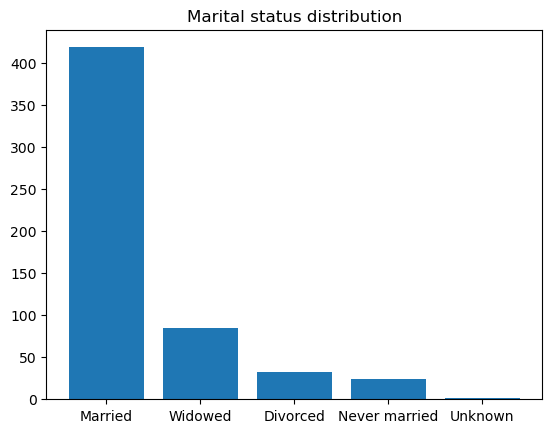

In [173]:
plt.bar(social_subjects['PTMARRY'].value_counts().index,
        social_subjects['PTMARRY'].value_counts())
plt.title('Marital status distribution')
plt.show()

**Years of education**

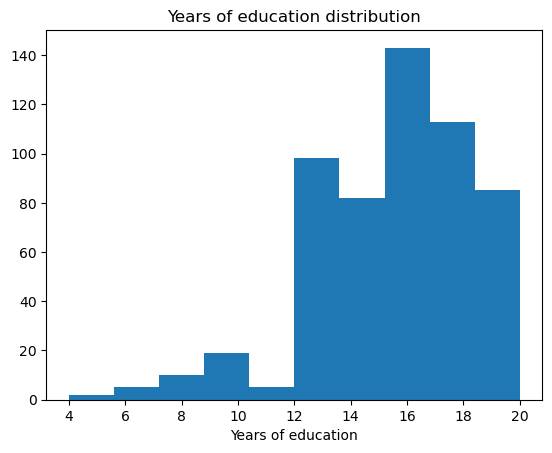

In [174]:
plt.hist(social_subjects['PTEDUCAT'])
plt.title('Years of education distribution')
plt.xlabel('Years of education')
plt.show()

**Home accomodation**

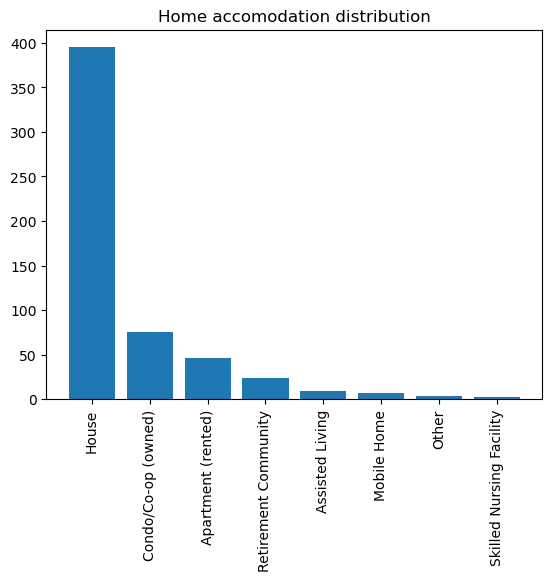

In [175]:
plt.bar(social_subjects['PTHOME'].value_counts().index,
        social_subjects['PTHOME'].value_counts())
plt.xticks(rotation='vertical')
plt.title('Home accomodation distribution')
plt.show()

**Main occupation (top 10)**
We analyzed only the top 10 occupations because the others are too few to be considered and there are too many of them

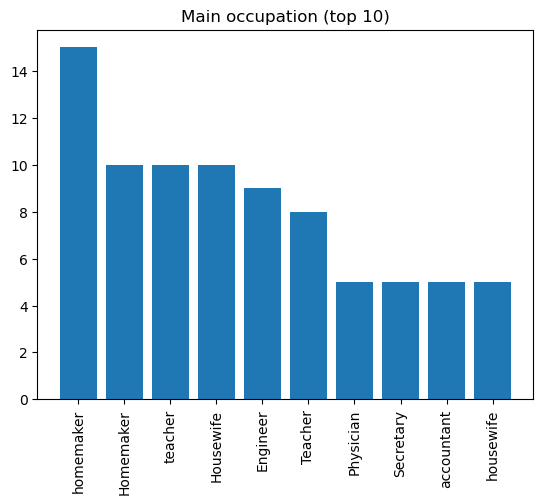

In [176]:
plt.bar(social_subjects['PTWORK'].value_counts()[:10].index,
        social_subjects['PTWORK'].value_counts()[:10])
plt.xticks(rotation='vertical')
plt.title('Main occupation (top 10)')
plt.show()

**Main occupation (top 10)**
We analyzed only the top 10 occupations because the others are too few to be considered and there are too many of them

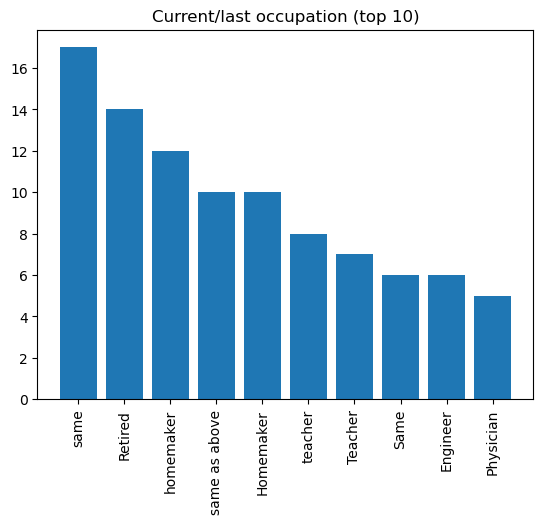

In [177]:
plt.bar(social_subjects['PTWRECNT'].value_counts()[:10].index,
        social_subjects['PTWRECNT'].value_counts()[:10])
plt.xticks(rotation='vertical')
plt.title('Current/last occupation (top 10)')
plt.show()

As we can see, the values from the job variables are inconsistent. Probably best not to use them

**Retirement yes/no**

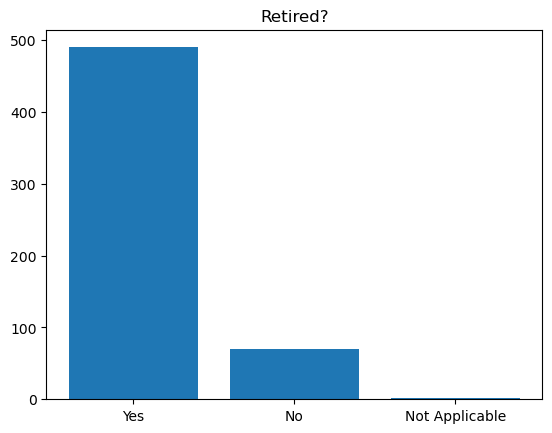

In [178]:
plt.bar(social_subjects['PTNOTRT'].value_counts().index,
        social_subjects['PTNOTRT'].value_counts())
plt.title('Retired?')
plt.show()

**Retirement date**:

As sad before, we have to ignore the values '-4'

In [179]:
ret_years = []

for i in range(len(social_subjects['PTRTYR'][social_subjects['PTRTYR'] != '-4'])):
    ret_years.append(int(str(social_subjects['PTRTYR'][social_subjects['PTRTYR'] != '-4'].iloc[i])[-4:]))

ret_years = list(set(ret_years))

ret_years_freq = []
for j in ret_years:
    freq = 0
    for i in range(len(social_subjects['PTRTYR'][social_subjects['PTRTYR'] != '-4'])):
        if(social_subjects['PTRTYR'][social_subjects['PTRTYR'] != '-4'].iloc[i])[-4:] == str(j):
            freq += 1
    
    ret_years_freq.append(int(freq))

Text(0.5, 1.0, 'Retirement date')

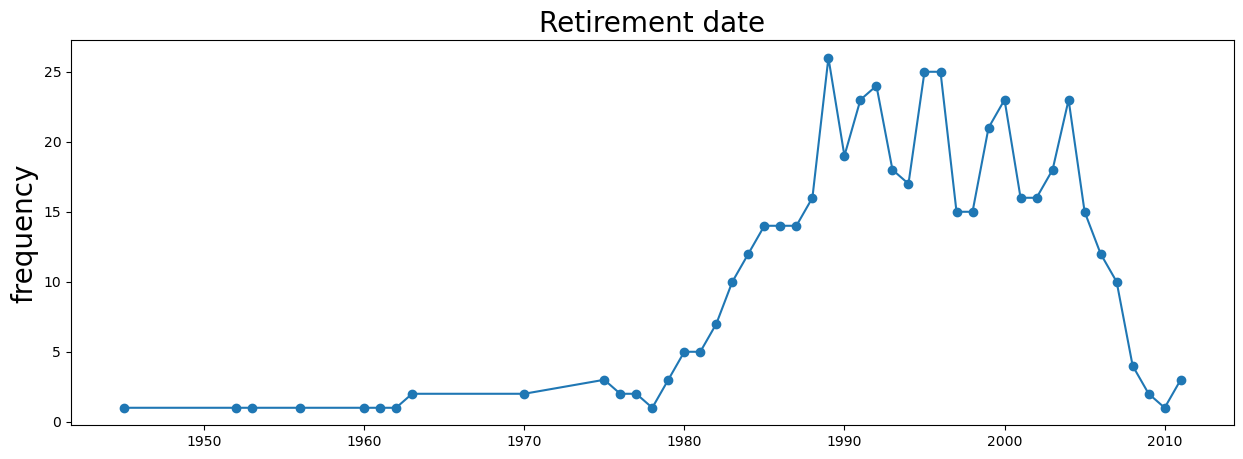

In [180]:
plt.figure(figsize=(15,5))
plt.plot(ret_years, ret_years_freq, 'o-')
plt.ylabel('frequency', size = 20)
plt.title('Retirement date', size = 20)

This attribute isn't really useful because we don't have much data about when the subjects were diagnosed with the disease (PTADDX has 60% missing values)

#### **Phisical attributes**

In [181]:
physical_attributes = ['PTGENDER', 'PTHAND', 'PTRACCAT', 'Weight', 'Age']

physical_subjects = unique_subjects[physical_attributes]

**Race**

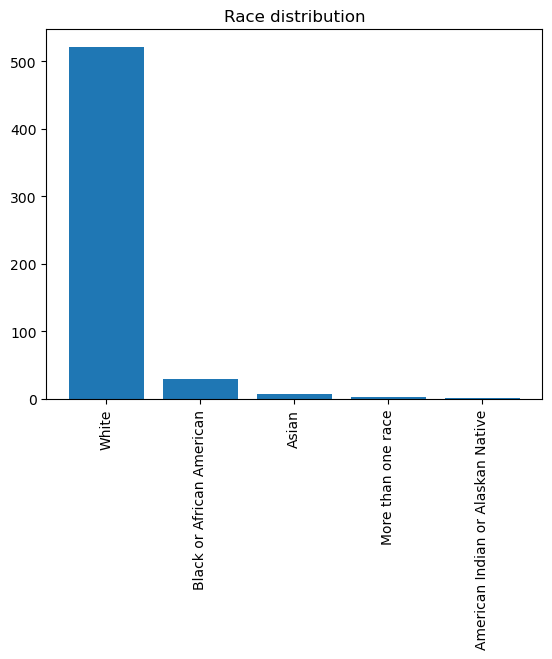

In [182]:
plt.bar(physical_subjects['PTRACCAT'].value_counts().index,
        physical_subjects['PTRACCAT'].value_counts())
plt.xticks(rotation='vertical')
plt.title('Race distribution')
plt.show()

**Dominant hand**

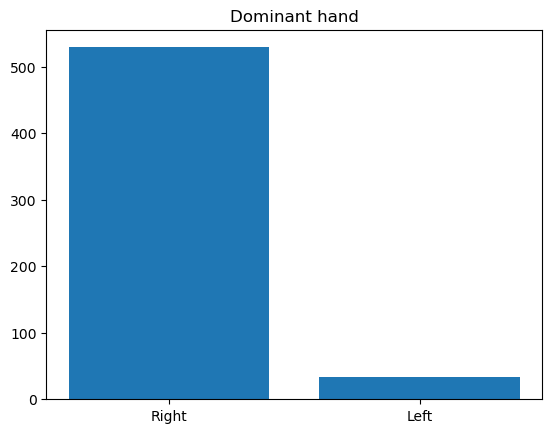

In [183]:
plt.bar(physical_subjects['PTHAND'].value_counts().index,
        physical_subjects['PTHAND'].value_counts())
plt.title('Dominant hand')
plt.show()

**Gender**

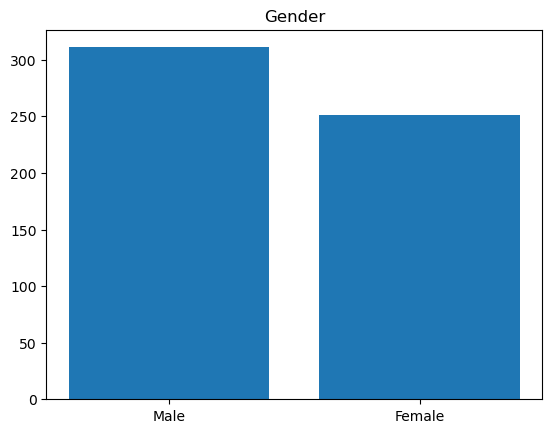

In [184]:
plt.bar(physical_subjects['PTGENDER'].value_counts().index,
        physical_subjects['PTGENDER'].value_counts())
plt.title('Gender')
plt.show()

**Weight**

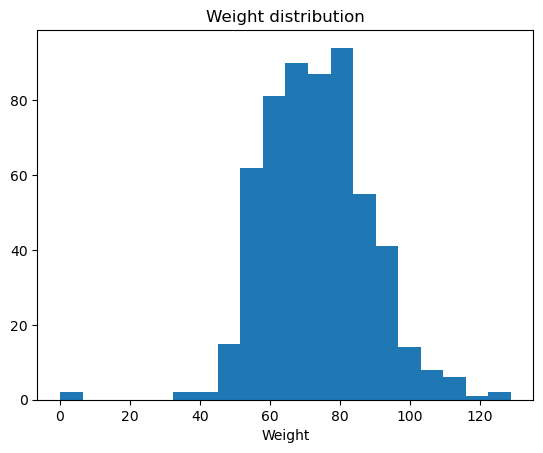

In [185]:
plt.hist(physical_subjects['Weight'], bins=20)
plt.title('Weight distribution')
plt.xlabel('Weight')
plt.show()

**Age**

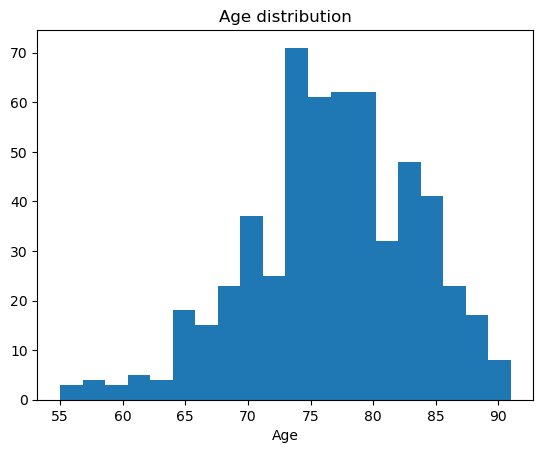

In [186]:
plt.hist(physical_subjects['Age'], bins=20)
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

#### **Genetic attributes**

We are going to analyse the ...

In [187]:
genetic_attributes = ['APOE A1', 'APOE A2', 'TOMM40_A1', 'TOMM40_A2']

genetic_subjects = unique_subjects[genetic_attributes]

##### **APOE**

In [188]:
genetic_subjects['APOE A1'] = genetic_subjects['APOE A1'].astype('category')

C:\Users\Emili\AppData\Local\Temp\ipykernel_12484\3747052874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetic_subjects['APOE A1'] = genetic_subjects['APOE A1'].astype('category')


**Allele 1**

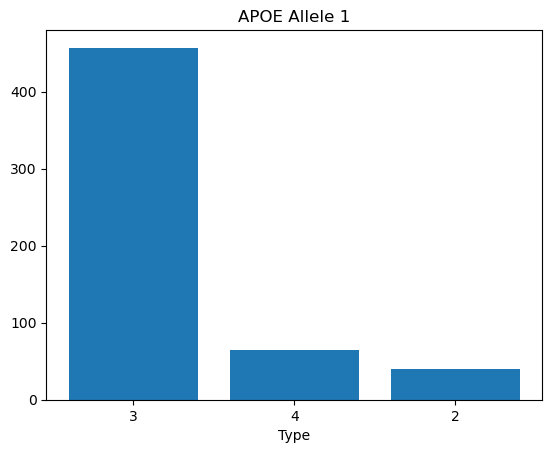

In [197]:
plt.bar(genetic_subjects['APOE A1'].value_counts().index,
        genetic_subjects['APOE A1'].value_counts())
plt.title('APOE Allele 1')
plt.xlabel('Type')
plt.show()

**Allele 2**

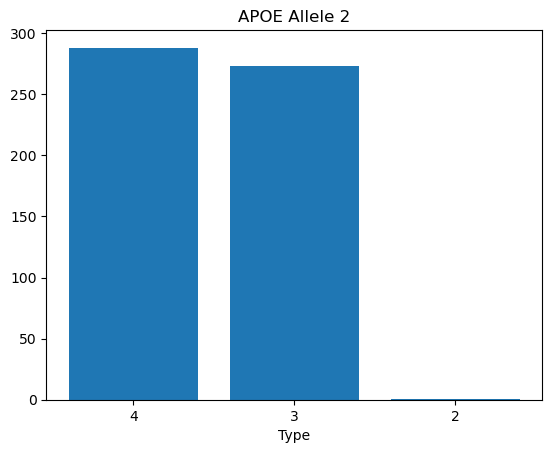

In [196]:
plt.bar(genetic_subjects['APOE A2'].value_counts().index,
        genetic_subjects['APOE A2'].value_counts())
plt.title('APOE Allele 2')
plt.xlabel('Type')
plt.show()

**Combined distribution**

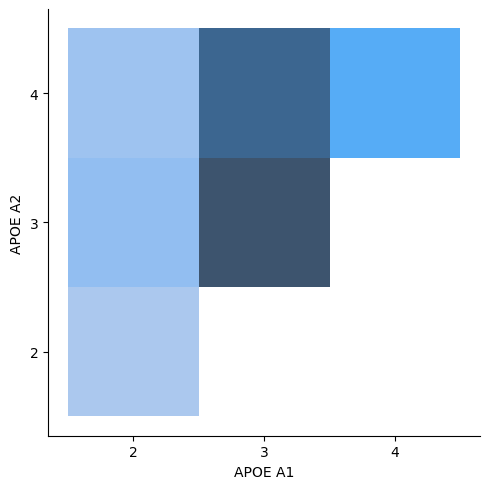

In [207]:
sns.displot(genetic_subjects, x="APOE A1", y="APOE A2");

##### **TOMM40**

**Allele 1**

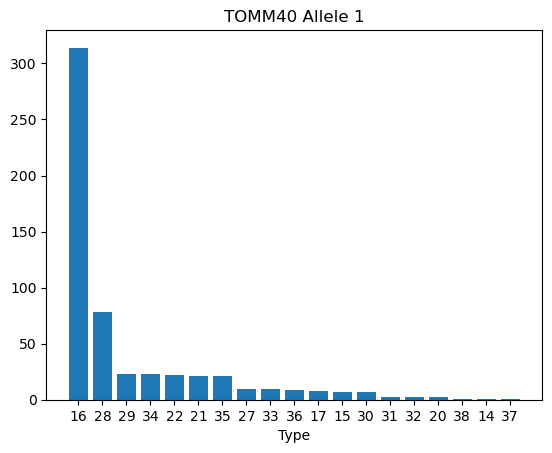

In [198]:
plt.bar(genetic_subjects['TOMM40_A1'].value_counts().index,
        genetic_subjects['TOMM40_A1'].value_counts())
plt.title('TOMM40 Allele 1')
plt.xlabel('Type')
plt.show()

**Allele 2**

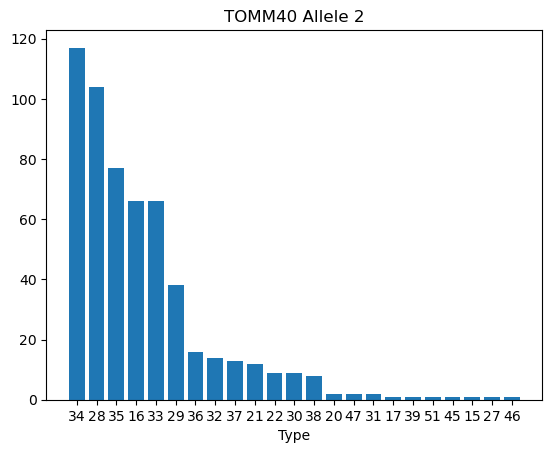

In [199]:
plt.bar(genetic_subjects['TOMM40_A2'].value_counts().index,
        genetic_subjects['TOMM40_A2'].value_counts())
plt.title('TOMM40 Allele 2')
plt.xlabel('Type')
plt.show()

**Combined distribution**

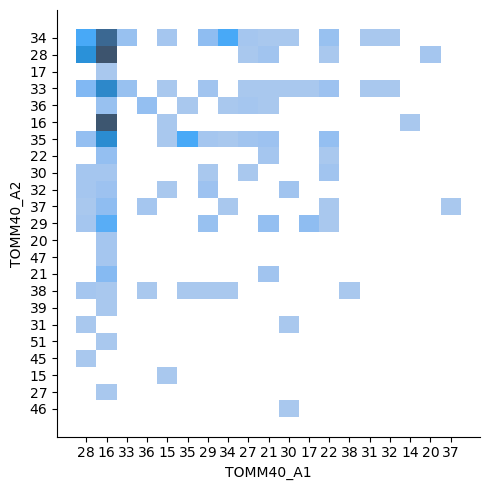

In [208]:
sns.displot(genetic_subjects, x="TOMM40_A1", y="TOMM40_A2");